In [2]:
import sys
sys.path.append('..//')

import jax
import numpy as np
import jax.numpy as jnp
from jax import jacfwd, jacrev
import matplotlib.pyplot as plt
import jax.scipy.linalg as jlinalg

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

from parsmooth import MVNStandard
from parsmooth import FunctionalModel
from parsmooth.sequential._filtering import filtering
from parsmooth.linearization import extended, extended_hessian
from parsmooth.sequential._filtering_Newton import filtering as newton_filtering
from parsmooth.sequential._smoothing_Newton import smoothing as newton_smoothing
from bearing_data import get_data, make_parameters

In [3]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step

T = 500
_, true_states, ys = get_data(x0, dt, r, T, s1, s2)

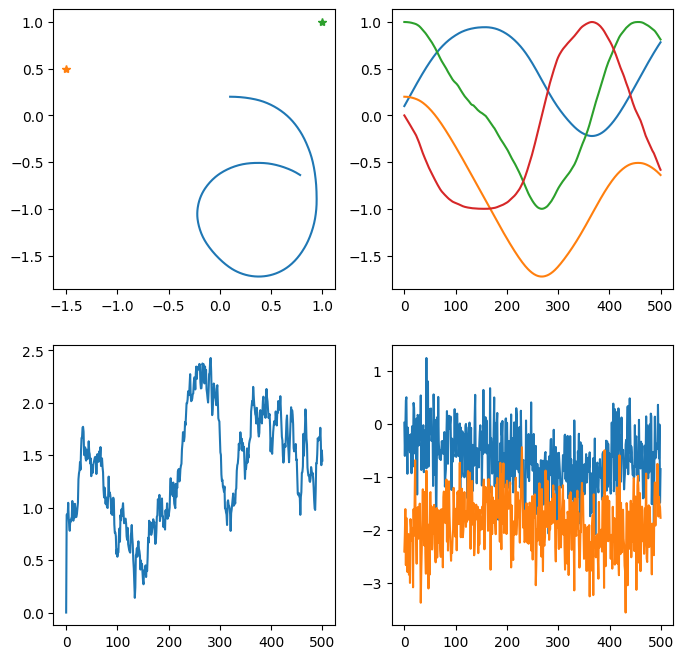

In [4]:
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.plot(true_states[:,0], true_states[:,1])
plt.plot(s1[0],s1[1], '*')
plt.plot(s2[0],s2[1], '*')
plt.subplot(2, 2, 2)
plt.plot(true_states[:,0:-1])
plt.subplot(2, 2, 3)
plt.plot(true_states[:,-1])
plt.subplot(2, 2, 4)
plt.plot(ys);

In [5]:
qc = 0.01  # discretization noise
qw = 10  # discretization noise
Q, R, observation_function, transition_function, observation_function_dx, transition_function_dx = make_parameters(qc, qw, r, dt, s1, s2)

chol_Q = jlinalg.cholesky(Q, lower=True)
chol_R = jlinalg.cholesky(R, lower=True)

m0 = jnp.array([0., 0., 1., 0., 0.])
P0 = jnp.diag(jnp.array([0.1, 0.1, 1., 1., 1.]))

# m0 = transition_function(jnp.array([0.1, 0.2, 1, 0, 0]) )
# P0 = Q

init = MVNStandard(m0, P0)

initial_states =  MVNStandard(jnp.repeat(jnp.array([[0., 0., 2., 7., 3.]]),T + 1, axis=0),
                                                     jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))

transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))
observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

## Check the derivative of observation function and transition function by hand vs grad

In [6]:
L0 = jlinalg.cholesky(P0, lower=True)
x_check = m0 + L0 @ np.random.normal(size=(m0.shape))

In [7]:
df_grad = jax.jacfwd(transition_function, argnums=0)(x_check)
df_hand = transition_function_dx(x_check)
np.testing.assert_array_almost_equal(df_grad, df_hand, decimal=10, err_msg = 'Derivative check failed.')

In [8]:
dh_grad = jax.jacfwd(observation_function, argnums=0)(x_check)
dh_hand = observation_function_dx(x_check)
np.testing.assert_array_almost_equal(dh_grad, dh_hand, decimal=10, err_msg = 'Derivative check failed.')

 ### Sequential solution- (Gauss-Newton)

In [9]:
#Filtering
filtered_states = filtering(ys, init, transition_model, observation_model, extended, initial_states)

### Batch solution

In [10]:
def mvn_loglikelihood(x, chol_cov):
    """multivariate normal"""
    dim = chol_cov.shape[0]
    y = jlinalg.solve_triangular(chol_cov, x, lower=True)
    normalizing_constant = (
            jnp.sum(jnp.log(jnp.abs(jnp.diag(chol_cov)))) + dim * jnp.log(2 * jnp.pi) / 2.0
    )
    norm_y = jnp.sum(y * y, -1)
    return -0.5 * norm_y - normalizing_constant

In [11]:
def LL(predict_trajectory, update_trajectory, z, measurement_fun, dynamic_fun, chol_Q, chol_R):
    mp_nominal = predict_trajectory
    mu_nominal = update_trajectory
    cost = mvn_loglikelihood(mu_nominal - dynamic_fun(mp_nominal), chol_Q) + mvn_loglikelihood(z - measurement_fun(mu_nominal), chol_R)
    return -cost

def state_space_cost(x):
    x0 = x[0]
    predict_traj =x[:-1]
    update_traj = x[1:]
    vmapped_fun = jax.vmap(LL, in_axes=[0, 0, 0, None, None, None, None])
    return jnp.sum(vmapped_fun(predict_traj, update_traj, ys, observation_function, transition_function, jnp.linalg.cholesky(Q), jnp.linalg.cholesky(R))) - mvn_loglikelihood(x0 - m0, jnp.linalg.cholesky(P0))


## Check the derivative of the additive state space cost function

\begin{equation}
\begin{split}
  L(\mathbf{x}_{0:3}) &= - \log p(\mathbf{x}_0) - \log p(\mathbf{x}_1 \mid \mathbf{x}_0) -\log p(\mathbf{y}_1 \mid \mathbf{x}_1)\\
   &- \log p(\mathbf{x}_2 \mid \mathbf{x}_1) - \log p(\mathbf{y}_2 \mid \mathbf{x}_2) \\
  &- \log p(\mathbf{x}_3 \mid \mathbf{x}_2) -\log p(\mathbf{y}_3 \mid \mathbf{x}_3) \\
  &= \frac{1}{2} (\mathbf{x}_0 - \mathbf{m}_0)^\top P_0^{-1} (\mathbf{x}_0 - \mathbf{m}_0)) + \frac{1}{2} (\mathbf{x}_{1} - f(\mathbf{x}_0))^\top Q^{-1} (\mathbf{x}_{1} - f(\mathbf{x}_0))+ \frac{1}{2} (\mathbf{y}_1 - h(\mathbf{x}_1))^\top R^{-1} (\mathbf{y}_1 - h(\mathbf{x}_1)) \\
  &\frac{1}{2} (\mathbf{x}_{2} - f(\mathbf{x}_1))^\top Q^{-1} (\mathbf{x}_{2} - f(\mathbf{x}_1))+ \frac{1}{2} (\mathbf{y}_2 - h(\mathbf{x}_2))^\top R^{-1} (\mathbf{y}_2 - h(\mathbf{x}_2))\\
  & \frac{1}{2} (\mathbf{x}_{3} - f(\mathbf{x}_3))^\top Q^{-1} (\mathbf{x}_{3} - f(\mathbf{x}_3))+ \frac{1}{2} (\mathbf{y}_3 - h(\mathbf{x}_3))^\top R^{-1} (\mathbf{y}_3 - h(\mathbf{x}_3))
\end{split}
\end{equation}


\begin{equation}
    \begin{split}
        \nabla L(\hat{\mathbf{x}}^{(i)}_{0:3}) &= \begin{bmatrix}
        \frac{\partial L}{\partial \mathbf{x}_0} (\hat{\mathbf{x}}_{0:3} ) \\
        \frac{\partial L}{\partial \mathbf{x}_1} (\hat{\mathbf{x}}_{0:3} )\\
        \frac{\partial L}{\partial \mathbf{x}_2} (\hat{\mathbf{x}}_{0:3} )\\
        \frac{\partial L}{\partial \mathbf{x}_3} (\hat{\mathbf{x}}_{0:3} )
        \end{bmatrix}= \begin{bmatrix}
    P_0^{-1} (\mathbf{x}_0 - \hat{\mathbf{m}}_0)
    -F^\top(\mathbf{x}_0) Q^{-1} (\mathbf{x}_1 - f(\mathbf{x}_0)) \\
    Q^{-1} (\mathbf{x}_1 - f(\mathbf{x}_0))
    -H^\top(\mathbf{x}_1) R^{-1} (\mathbf{y}_1 - h(\mathbf{x}_1))
    -F^\top(\mathbf{x}_1) Q^{-1} (\mathbf{x}_2 - f(\mathbf{x}_1)) \\
    Q^{-1} (\mathbf{x}_2 - f(\mathbf{x}_1))
    -H^\top(\mathbf{x}_2) R^{-1} (\mathbf{y}_2 - h(\mathbf{x}_2))
    -F^\top(\mathbf{x}_2) Q^{-1} (\mathbf{x}_3 - f(\mathbf{x}_2)) \\
    Q^{-1} (\mathbf{x}_3 - f(\mathbf{x}_2))
    -H^\top(\mathbf{x}_3) R^{-1} (\mathbf{y}_3 - h(\mathbf{x}_2))
  \end{bmatrix}
    \end{split}
\end{equation}

In [37]:
def _first(_P0, _x0, _m0 , _F, _Q, _x1, _f):
    inv_P0 = jnp.linalg.inv(_P0)
    inv_Q = jnp.linalg.inv(_Q)
    return inv_P0 @ (_x0 - _m0) - _F(_x0).T @ inv_Q @ (_x1 - _f(_x0))

def _general(x_k_1, x_k, x_k_p_1, _y, _f, _h, _F, _H, _Q, _R):
    inv_Q = jnp.linalg.inv(_Q)
    inv_R = jnp.linalg.inv(_R)
    return inv_Q @ (x_k - _f(x_k_1)) - _H(x_k).T @ inv_R @ (_y - _h(x_k)) - _F(x_k).T @ inv_Q @ (x_k_p_1 - _f(x_k))

def _last(x, _y, _f, _h, _F, _H, _Q, _R):
    x_N_1 = x[0]
    x_N = x[1]
    inv_Q = jnp.linalg.inv(_Q)
    inv_R = jnp.linalg.inv(_R)
    return inv_Q @ (x_N - _f(x_N_1)) - _H(x_N).T @ inv_R @ (_y - _h(x_N))

def derivative_state_space_cost(x):
    x_k_1 = x[:-2]
    x_k = x[1:-1]
    x_k_p_1 = x[2:]
    first_element = _first(P0, x[0], m0 , transition_function_dx, Q, x[1], transition_function).reshape(1,-1)
    vmapped_fun_dd = jax.vmap(_general, in_axes=[0, 0, 0, 0, None, None, None, None, None, None])
    middle_elements = vmapped_fun_dd(x_k_1, x_k, x_k_p_1, ys[:-1], transition_function, observation_function, transition_function_dx, observation_function_dx, Q, R)
    last_element = _last(x[-2:], ys[-1], transition_function, observation_function, transition_function_dx, observation_function_dx, Q, R).reshape(1,-1)
    return jnp.array(jnp.concatenate([first_element, middle_elements, last_element], axis=0))

In [36]:
initial_states.mean[-4:]

Array([[0., 0., 2., 7., 3.],
       [0., 0., 2., 7., 3.],
       [0., 0., 2., 7., 3.],
       [0., 0., 2., 7., 3.]], dtype=float64)

In [39]:
derivative_state_space_cost(initial_states.mean)[-1]

Array([-24001894.98299865, -84006269.70851302,    117918.78556754,
          420662.76839737,         0.        ], dtype=float64)

In [40]:
jax.grad(state_space_cost, argnums=0)(initial_states.mean)[-1]

Array([-24001894.98299867, -84006269.7085131 ,    117918.78556754,
          420662.76839737,         0.        ], dtype=float64)

In [51]:
def _first(_P0, _x0, _m0 , _F, _Q, _x1, _f):
    inv_P0 = jnp.linalg.inv(_P0)
    inv_Q = jnp.linalg.inv(_Q)
    return inv_P0 @ (_x0 - _m0) - _F(_x0).T @ inv_Q @ (_x1 - _f(_x0))
x0 = initial_states.mean[0]
x1 = initial_states.mean[1]
_first(P0, x0, m0 , transition_function_dx, Q, x1, transition_function).reshape(1,-1).shape

(1, 5)

In [28]:
jnp.linalg.inv(P0) @ (initial_states.mean[0] - m0) - transition_function_dx(initial_states.mean[0]).T@ jnp.linalg.inv(Q)@(initial_states.mean[1] - transition_function(initial_states.mean[0]))

Array([2.40018943e+07, 8.40062722e+07, 1.22136210e+05, 4.19533215e+05,
       4.79914144e+02], dtype=float64)

In [31]:
jnp.linalg.inv(Q)@(initial_states.mean[1] - transition_function(initial_states.mean[0])) - observation_function_dx(initial_states.mean[1]).T @ jnp.linalg.inv(R) @ (ys[0] - observation_function(initial_states.mean[1])) - transition_function_dx(initial_states.mean[1]).T@ jnp.linalg.inv(Q)@(initial_states.mean[2] - transition_function(initial_states.mean[1]))

Array([-9.67113353e-01, -1.67054757e-01,  2.40053995e+05,  8.40188983e+05,
        4.76914144e+02], dtype=float64)

In [32]:
jnp.linalg.inv(Q)@(initial_states.mean[500] - transition_function(initial_states.mean[499])) - observation_function_dx(initial_states.mean[500]).T @ jnp.linalg.inv(R) @ (ys[499] - observation_function(initial_states.mean[500]))

Array([-24001895.7712479 , -84006269.06638956,    117918.78556754,
          420662.76839737,         0.        ], dtype=float64)

In [37]:
jax.grad(state_space_cost, argnums=0)(initial_states.mean)[-1]

Array([-24001895.77124793, -84006269.06638964,    117918.78556754,
          420662.76839737,         0.        ], dtype=float64)

In [ ]:
def grad_hand():
    jnp.linalg.inv(P0) @ (x0 - m0)
    jnp.array([])

In [12]:
grad = jax.grad(state_space_cost, argnums=0)(initial_states.mean)
Hess = jacfwd(jacrev(state_space_cost))(initial_states.mean)

x_batch = initial_states.mean - jax.numpy.linalg.tensorsolve(Hess, grad)

### Sequential solution - Newton

In [13]:
# Filtering - Newton
filtered_states_newton = newton_filtering(ys, init, transition_model, observation_model, extended_hessian, initial_states, False)
# Smoothing - Newton
smoothed_states_newton = newton_smoothing(transition_model, filtered_states_newton,  extended, initial_states)

/Users/yaghoof1/PycharmProjects/Newton-KS/notebooks/../parsmooth/sequential/_smoothing_Newton.py:52: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  gain = Pf @ jlag.solve(S, F, sym_pos=True).T


In [14]:
filtered_states_newton.mean

Array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [-0.0709948 , -0.0096328 ,  2.8021964 ,  6.92983042,  2.89015357],
       [ 0.04106393,  0.06579648,  2.93876596,  6.80653062,  2.96389586],
       ...,
       [        nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan]],      dtype=float64)

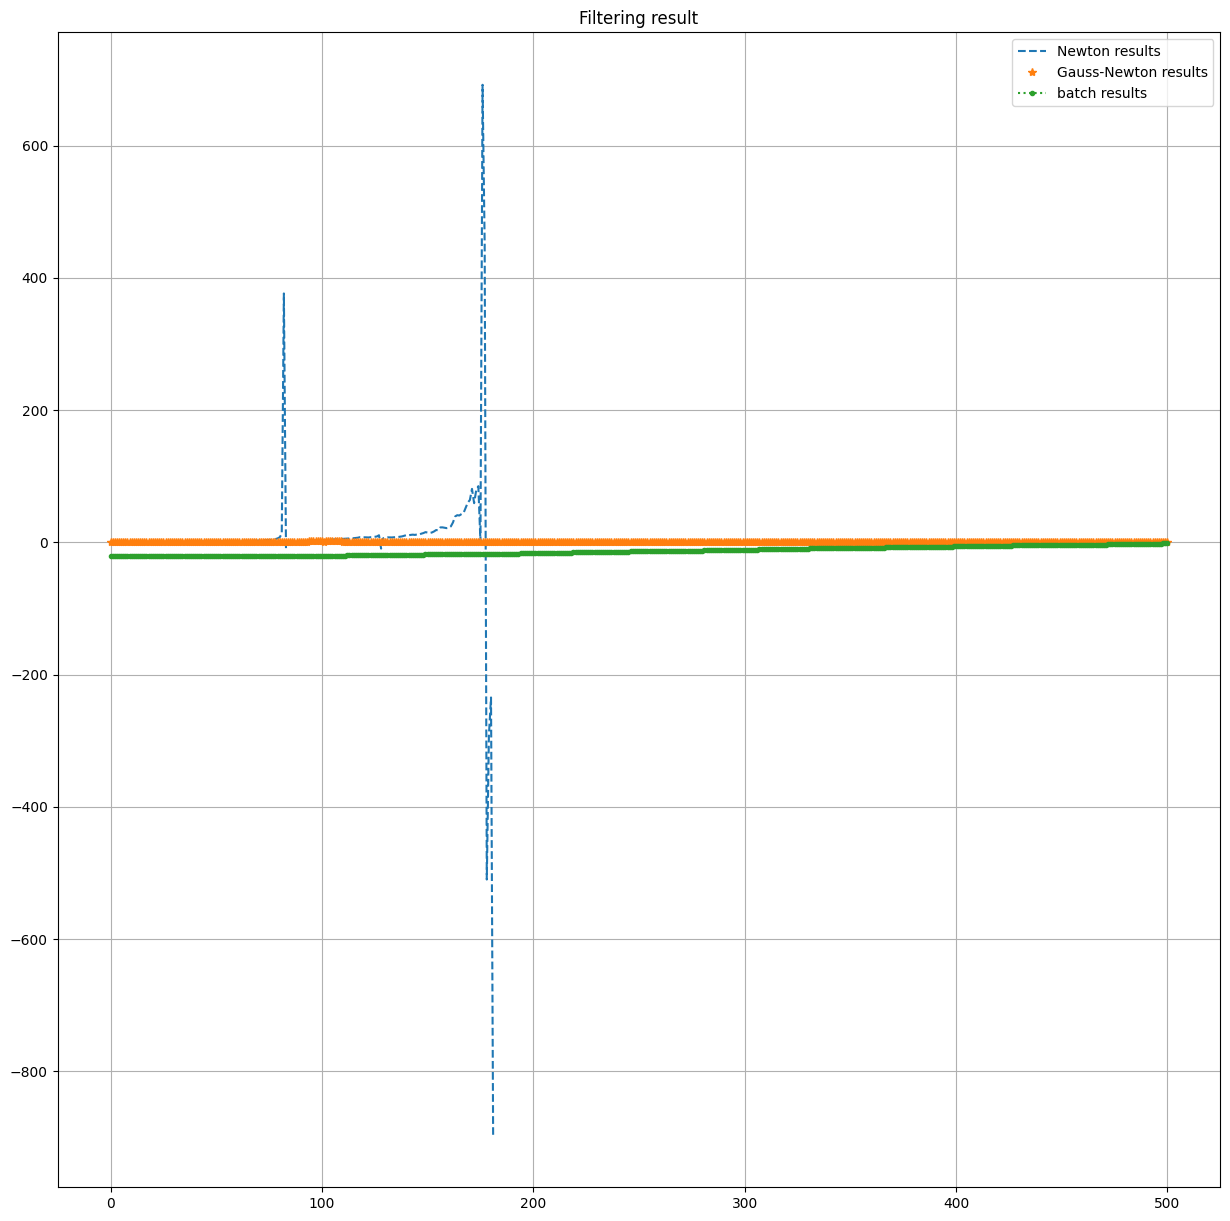

In [15]:
plt.figure(figsize=(15,15))
plt.plot(filtered_states_newton.mean[:,0], "--", label="Newton results" )
plt.plot(filtered_states.mean[:,0], "*", label = "Gauss-Newton results")
plt.plot(x_batch[:,0], ".:", label = "batch results")
plt.title("Filtering result")
plt.grid()
plt.legend();